In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
%matplotlib inline

In [3]:
# Import state vector file using geopandas
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [19]:
# Choose two U and V files for the same time-period
fNameVa='/glade/scratch/currierw/ACCESS1-0/historical/va_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameUa='/glade/scratch/currierw/ACCESS1-0/historical/ua_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'

# open the datasets (ds) with xarray
vads=xr.open_dataset(fNameVa)
uads=xr.open_dataset(fNameUa) 

uads

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 145, lev: 38, lon: 192, time: 1464)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T06:00:00 ... 1981-01-01
  * lev       (lev) float64 9.998 50.0 130.0 ... 2.79e+04 3.106e+04 3.608e+04
  * lat       (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon       (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 ...
    b         (lev) float64 ...
    orog      (lat, lon) float32 ...
    b_bnds    (lev, bnds) float64 ...
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    ua        (time, lev, lat, lon) float32 ...
Attributes:
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    parent_experiment_id:   piControl
    parent_experiment_rip:  r1i1p1
    branch_time:            109207.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    history:                CMIP5 compliant file produced from raw ACCESS mod...
    references:             See http://wiki.csiro.au/confluence/display/ACCES...
    initialization_method:  1
    physics_version:        1
    tracking_id:            f054dd0e-9202-42db-8ac7-b74baa45df9e
    version_number:         v20120115
    product:                output
    experiment:             historical
    frequency:              6hr
    creation_date:          2012-03-13T16:25:44Z
    Conventions:            CF-1.4
    project_id:             CMIP5
    table_id:               Table 6hrLev (01 February 2012) c5123c86b3fd5e934...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

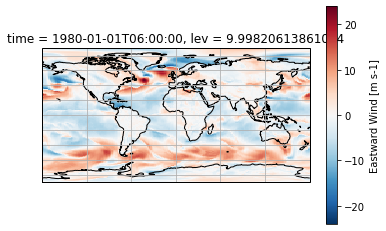

In [5]:
# Original 
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())

p = uads['ua'][0,0,:,:].plot(x='lon', y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})
ax.coastlines();ax.gridlines();plt.draw();

In [6]:
# Slice/Subset data down further based on latitutde (-90 -- +90), longitude (0 -- 360)
lat_bnds, lon_bnds = [20, 55], [220, 260]
vads_sub=vads.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds)) # subset the Va data
uads_sub=uads.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds)) # subset the Ua data

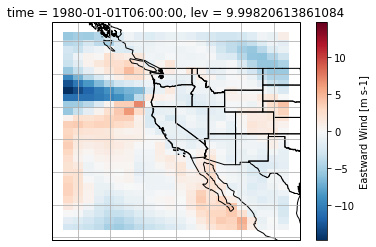

In [10]:
# What do these subsetted data data look ike?
ax = plt.axes(projection=ccrs.PlateCarree())
p = uads_sub['ua'][0,0,:,:].plot(x='lon', y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})

ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

In [11]:
# Create new coordiantes within the subsetted data
vads_sub['lat']=vads_sub.lat.rename({'lat':'lat_va'})
vads_sub['lon']=vads_sub.lon.rename({'lon':'lon_va'})

uads_sub['lat']=uads_sub.lat.rename({'lat':'lat_ua'})
uads_sub['lon']=uads_sub.lon.rename({'lon':'lon_ua'})

# Create New Datasets that's just the datasets with dimensions and coordinates
ds_v=xr.Dataset({"v":(("time","lev","lat_va","lon_va"),vads_sub.va)},
                 coords={"time":vads_sub.time,"lev":vads_sub.lev,"lat_va":vads_sub.lat_va,"lon_va":vads_sub.lon_va})

ds_u=xr.Dataset({"u":(("time","lev","lat_ua","lon_ua"),uads_sub.ua)},
                 coords={"time":uads_sub.time,"lev":uads_sub.lev,"lat_ua":uads_sub.lat_ua,"lon_ua":uads_sub.lon_ua})

print(ds_v.v.shape) 
print(ds_u.u.shape)

(1464, 38, 28, 21)
(1464, 38, 29, 22)


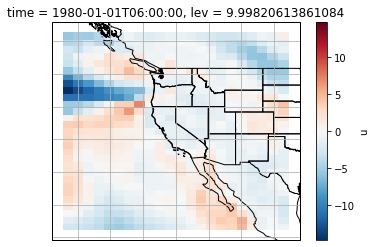

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds_u['u'][0,0,:,:].plot(x='lon_ua', y='lat_ua',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})

ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

In [14]:
# Make a new dataset
ds=xr.merge([ds_u,ds_v],compat='override')

In [15]:
ds

<xarray.Dataset>
Dimensions:  (lat_ua: 29, lat_va: 28, lev: 38, lon_ua: 22, lon_va: 21, time: 1464)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T06:00:00 ... 1981-01-01
  * lev      (lev) float64 9.998 50.0 130.0 ... 2.79e+04 3.106e+04 3.608e+04
    lat      (lat_ua) float64 20.0 21.25 22.5 23.75 ... 51.25 52.5 53.75 55.0
  * lat_ua   (lat_ua) float64 20.0 21.25 22.5 23.75 ... 51.25 52.5 53.75 55.0
    lon      (lon_ua) float64 220.3 222.2 224.1 225.9 ... 255.9 257.8 259.7
  * lon_ua   (lon_ua) float64 220.3 222.2 224.1 225.9 ... 255.9 257.8 259.7
  * lat_va   (lat_va) float64 20.62 21.88 23.12 24.38 ... 51.88 53.12 54.38
  * lon_va   (lon_va) float64 221.2 223.1 225.0 226.9 ... 255.0 256.9 258.8
Data variables:
    u        (time, lev, lat_ua, lon_ua) float32 -2.7173824 ... -30.476933
    v        (time, lev, lat_va, lon_va) float32 1.899821 1.371231 ... -38.60249

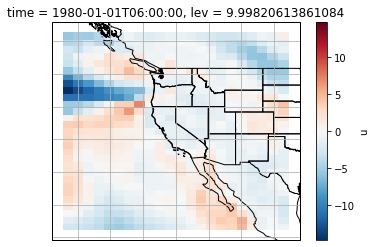

In [18]:
# Check to make sure the plot is the same as before
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds['u'][0,0,:,:].plot(x='lon_ua', y='lat_ua',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.gridlines()
ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

In [ ]:
# Extra Info
print("    Latitude")
print("")
print("vads and uads grid increases in latitude by 1.25°")
print("")
print("vads lat grid starts at 20.62°, uads lat grid starts at 20°,\nslice initiated at 20°")
print("")
print("vads and uads latitudes differ by 0.625° "+ \
      "\nwhich is 1/2 of the increase in latitude")
print("")

print("    Longitude")
print("")
print("vads and uads grid increases in longitude by 1.875°")
print("")
print("vads lon grid starts at 221.2°, uads lon grid starts at 220.3°,\nslice initiated at 220°")
print("")
print("vads and uads longitudes differ by 0.9375° "+ \
      "\nwhich is 1/2 of the increase in longitudes")
